In [1]:
import rhs
import gauss_legendre as gl
import numpy as np
import matplotlib.pyplot as plt
import h5py

Integrating: 100%|██████████| 1094/1094 [02:51<00:00,  6.37step/s]


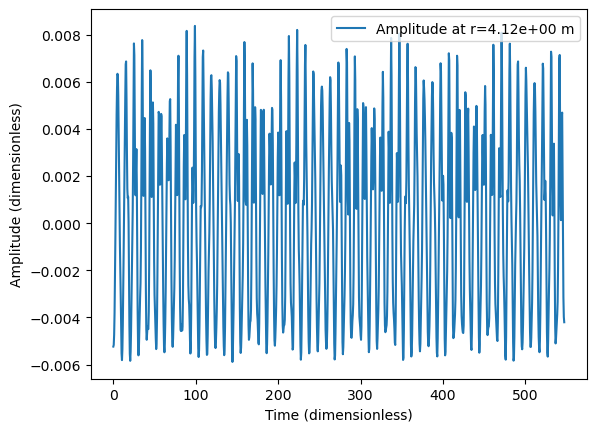

In [4]:
simManager = rhs.SimulationManager(r"C:\Users\emore\source\repos\Bouwmeester-Lab\superfluid-dynamics\CuSuperHelium\x64\Release\CuSuperHelium.dll")
def rhs_func(t, y, L = 1e-6, depth = 15e-9):
        N = 64
        local_x = y[:N]
        local_ampl = y[N:2*N]
        local_pot = y[2*N:3*N]
        res, vx, vy, dphi = simManager.calculate_rhs_from_vectors(local_x, local_ampl, local_pot, L, 145, 0, depth)
        if res != 0:
            raise Exception("Error in calculation")
        return np.concatenate((vx, vy, dphi))
L = 1e-6
depth = 15e-9

def f(y):
    return rhs_func(0, y, L, depth)

def J(y):
    N = 64
    local_x = y[:N]
    local_ampl = y[N:2*N]
    local_pot = y[2*N:3*N]
    res, jacobian = simManager.calculate_jacobian(local_x, local_ampl, local_pot, L, 145, 0, depth)
    if jacobian is None or res != 0:
        raise Exception("Error in Jacobian calculation")
    return jacobian

N = 64
r = np.array([2.0*np.pi/N*x for x in range(N)])
initial_amplitude = 0.1*depth
L0 = L / (2.0 * np.pi)

ampl = np.cos(r) * initial_amplitude / L0
pot = initial_amplitude/L0 * np.sin(r)

y0 = np.concatenate((r, ampl, pot))

t0, t1, h = 0.0, 547, 0.5
T, Y = gl.integrate_gl2(f, J, y0, t0, t1, h, simplified=True, newton_maxit = 100)

r0 = r[N//2+10]
plt.figure()
plt.plot(T, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")
plt.xlabel("Time (dimensionless)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()

In [5]:
T1, Y1 = gl.integrate_gl2(f, J, Y[-1, :], t0, 0.27, 0.01*h, simplified=True, newton_maxit = 100)

Integrating: 100%|██████████| 54/54 [00:04<00:00, 11.55step/s]


In [16]:
print(f"TIme: {T[1250]}")

TIme: 100.0


In [7]:
with h5py.File("simulation.h5", "w") as file:
    file.create_dataset("T", data=T)
    file.create_dataset("Y", data=Y)

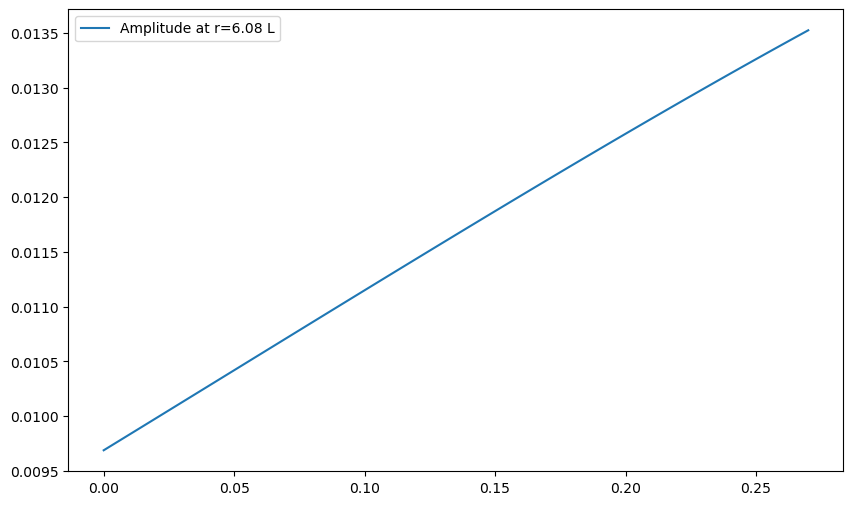

In [6]:
from scipy.interpolate import interp1d

def extrapolate(x, y, x0):
    f = interp1d(x, y, fill_value="extrapolate")
    return f(x0)

amplitudes = []
for i in range(len(T1)):
    t = T[i]
    val = extrapolate(Y1[i, :N], Y1[i, N:2*N], 2*np.pi - 0.2)
    amplitudes.append(val)

plt.figure(figsize=(10,6))
plt.plot(T1, amplitudes, label=f"Amplitude at r={2*np.pi - 0.2:.2f} L")
plt.legend()

100%|██████████| 1095/1095 [00:41<00:00, 26.10it/s]


ValueError: x and y must have same first dimension, but have shapes (55,) and (1095,)

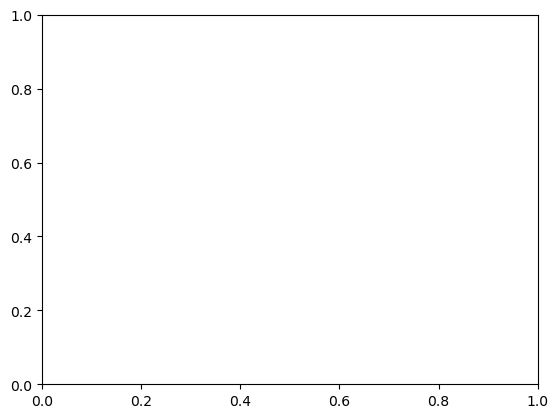

In [ ]:
import tqdm


t = 11
max_real_pos = []
for t in tqdm.tqdm(range(T.shape[0])):
    res, J = simManager.calculate_jacobian(Y[t, :N], Y[t, N:2*N], Y[t, 2*N:3*N], L, 145, 0, depth)
    eigvals = np.linalg.eigvals(J)
    max_real_pos.append(np.max(eigvals.real))

plt.plot(T, max_real_pos, label="Max real part of eigenvalues")

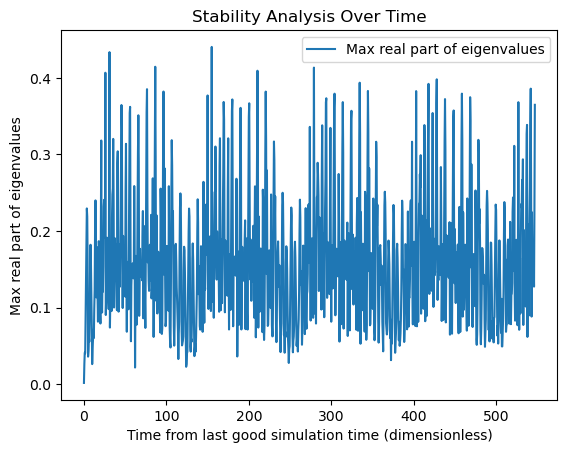

In [10]:

plt.plot(T, max_real_pos, label="Max real part of eigenvalues")
plt.xlabel("Time from last good simulation time (dimensionless)")
plt.ylabel("Max real part of eigenvalues")
plt.legend()
plt.title("Stability Analysis Over Time")
plt.show()

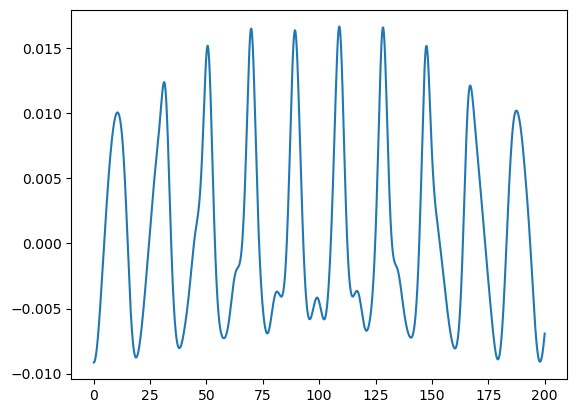

In [18]:
plt.plot(T, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")

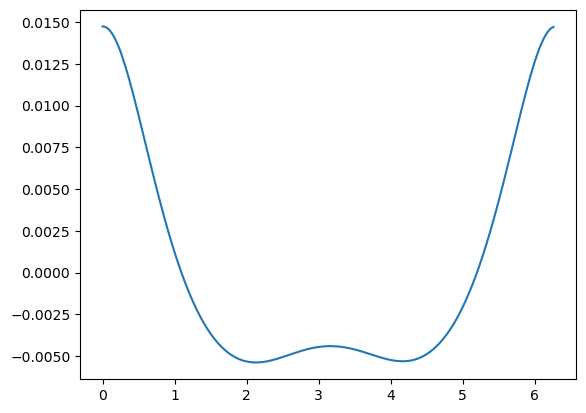

In [17]:
plt.plot(r, Y[1250, N:2*N], label="Initial amplitude")

In [3]:
with h5py.File("simulation.h5", "r") as file:
    T = file["T"][:]
    Y = file["Y"][:]
    

In [8]:
%matplotlib Qt

In [9]:
from matplotlib.animation import FuncAnimation
N = 256
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlim(Y[0, 0], Y[0, N-1])
    ax.set_ylim(Y[:, N:2*N].min(), Y[:, N:2*N].max())
    return line,

def update(frame):
    line.set_data(Y[frame, :N], Y[frame, N:2*N])
    return line,

ani = FuncAnimation(fig, update, frames=len(T), init_func=init, blit=True)
plt.show()